# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from gensim.models import Word2Vec

# Ensure nltk resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load the data
train_df = pd.read_csv('https://raw.githubusercontent.com/narendranathreddy333/DATA/main/stsa-train.txt', header=None, sep='\t', names=['data'])
test_df = pd.read_csv('https://raw.githubusercontent.com/narendranathreddy333/DATA/main/stsa-test.txt', header=None, sep='\t', names=['data'])

# Separate the label and text
train_df['label'] = train_df['data'].apply(lambda x: int(x[0]))
train_df['text'] = train_df['data'].apply(lambda x: x[2:])
test_df['label'] = test_df['data'].apply(lambda x: int(x[0]))
test_df['text'] = test_df['data'].apply(lambda x: x[2:])

# Drop the original combined column
train_df.drop('data', axis=1, inplace=True)
test_df.drop('data', axis=1, inplace=True)

# Preprocessing function to clean text
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [w for w in tokens if not w in stop_words]
    return " ".join(filtered_tokens)

train_df['text'] = train_df['text'].apply(preprocess)
test_df['text'] = test_df['text'].apply(preprocess)

# Vectorization with TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])

# Train a Word2Vec model
tokenized_train = [word_tokenize(text) for text in train_df['text']]
tokenized_test = [word_tokenize(text) for text in test_df['text']]
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4)

def feature_vector(text, model):
    words = set(model.wv.index_to_key)
    word_vecs = [model.wv[word] for word in text if word in words]
    if len(word_vecs) > 0:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(100)

X_train_w2v = np.array([feature_vector(text, w2v_model) for text in tokenized_train])
X_test_w2v = np.array([feature_vector(text, w2v_model) for text in tokenized_test])

y_train = train_df['label']
y_test = test_df['label']

# Model setup
models = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(3),
    'DecisionTree': DecisionTreeClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'RandomForest_TFIDF': RandomForestClassifier(),
    'RandomForest_Word2Vec': RandomForestClassifier()
}

# Evaluate models using 10-fold cross-validation and on the test set
kf = KFold(n_splits=10, random_state=42, shuffle=True)
for name, model in models.items():
    if 'RandomForest' not in name:  # Evaluate using TF-IDF
        cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf)
        print(f"{name} with TF-IDF - 10-fold CV Accuracy: {cv_scores.mean()}")
        model.fit(X_train_tfidf, y_train)
    elif 'TFIDF' in name:
        cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf)
        print(f"{name} - 10-fold CV Accuracy: {cv_scores.mean()}")
        model.fit(X_train_tfidf, y_train)
    else:  # Evaluate using Word2Vec
        cv_scores = cross_val_score(model, X_train_w2v, y_train, cv=kf)
        print(f"{name} - 10-fold CV Accuracy: {cv_scores.mean()}")
        model.fit(X_train_w2v, y_train)

    # Evaluation on the test set
    if 'Word2Vec' in name:
        predictions = model.predict(X_test_w2v)
    else:
        predictions = model.predict(X_test_tfidf)

    print(f"{name} - Test Accuracy: {accuracy_score(y_test, predictions)}")
    print(f"{name} - Precision: {precision_score(y_test, predictions, average='macro')}")
    print(f"{name} - Recall: {recall_score(y_test, predictions, average='macro')}")
    print(f"{name} - F1 Score: {f1_score(y_test, predictions, average='macro')}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


MultinomialNB with TF-IDF - 10-fold CV Accuracy: 0.7820809248554913
MultinomialNB - Test Accuracy: 0.7973640856672158
MultinomialNB - Precision: 0.8079371599367754
MultinomialNB - Recall: 0.7975164292745065
MultinomialNB - F1 Score: 0.79566608939983
SVM with TF-IDF - 10-fold CV Accuracy: 0.7833815028901735
SVM - Test Accuracy: 0.8056013179571664
SVM - Precision: 0.8077289728705705
SVM - Recall: 0.8056695472178796
SVM - F1 Score: 0.8052884092606062
KNN with TF-IDF - 10-fold CV Accuracy: 0.4845375722543353
KNN - Test Accuracy: 0.5068643602416255
KNN - Precision: 0.6466791284537649
KNN - Recall: 0.5060578426263679
KNN - F1 Score: 0.3507253258963739
DecisionTree with TF-IDF - 10-fold CV Accuracy: 0.6595375722543353
DecisionTree - Test Accuracy: 0.6688632619439868
DecisionTree - Precision: 0.6690253357163559
DecisionTree - Recall: 0.6688361270337561
DecisionTree - F1 Score: 0.6687609746797678
XGBoost with TF-IDF - 10-fold CV Accuracy: 0.6846820809248555
XGBoost - Test Accuracy: 0.7067545304

In [ ]:
'''

The code was similar to previous ones, but I added BERT this time,
which made the code run longer and eventually crash.
'''


# Write your code here
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split

# Ensure nltk resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load the data
train_df = pd.read_csv('https://raw.githubusercontent.com/narendranathreddy333/DATA/main/stsa-train.txt', header=None, sep='\t', names=['data'])
test_df = pd.read_csv('https://raw.githubusercontent.com/narendranathreddy333/DATA/main/stsa-test.txt', header=None, sep='\t', names=['data'])

# Separate the label and text
train_df['label'] = train_df['data'].apply(lambda x: int(x[0]))
train_df['text'] = train_df['data'].apply(lambda x: x[2:])
test_df['label'] = test_df['data'].apply(lambda x: int(x[0]))
test_df['text'] = test_df['data'].apply(lambda x: x[2:])

# Drop the original combined column
train_df.drop('data', axis=1, inplace=True)
test_df.drop('data', axis=1, inplace=True)

# Preprocessing function to clean text
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [w for w in tokens if not w in stop_words]
    return " ".join(filtered_tokens)

train_df['text'] = train_df['text'].apply(preprocess)
test_df['text'] = test_df['text'].apply(preprocess)

# Vectorization with TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])

# Train a Word2Vec model
tokenized_train = [word_tokenize(text) for text in train_df['text']]
tokenized_test = [word_tokenize(text) for text in test_df['text']]
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, workers=4)

def feature_vector(text, model):
    words = set(model.wv.index_to_key)
    word_vecs = [model.wv[word] for word in text if word in words]
    if len(word_vecs) > 0:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(100)

X_train_w2v = np.array([feature_vector(text, w2v_model) for text in tokenized_train])
X_test_w2v = np.array([feature_vector(text, w2v_model) for text in tokenized_test])

# BERT tokenizer and model loading
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def bert_encode(texts, tokenizer, model, max_len=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoded_batch = tokenizer.batch_encode_plus(texts, add_special_tokens=True, max_length=max_len, padding=True, truncation=True, return_tensors="pt")
    input_ids, attention_mask = encoded_batch['input_ids'].to(device), encoded_batch['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state[:,0,:].detach().cpu().numpy()  # Take the embeddings from the first token ([CLS] token)
    return embeddings

X_train_bert = bert_encode(train_df['text'].tolist(), tokenizer, bert_model)
X_test_bert = bert_encode(test_df['text'].tolist(), tokenizer, bert_model)

y_train = train_df['label']
y_test = test_df['label']

# Model setup
models = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(),
'KNN': KNeighborsClassifier(3),
'DecisionTree': DecisionTreeClassifier(),
'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
'RandomForest_TFIDF': RandomForestClassifier(),
'RandomForest_Word2Vec': RandomForestClassifier(),
'RandomForest_BERT': RandomForestClassifier()  # This will use BERT embeddings
}

# Evaluate models using 10-fold cross-validation and on the test set
kf = KFold(n_splits=10, random_state=42, shuffle=True)
for name, model in models.items():
    if 'RandomForest' not in name:  # Evaluate using TF-IDF
        cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf)
        print(f"{name} with TF-IDF - 10-fold CV Accuracy: {cv_scores.mean()}")
        model.fit(X_train_tfidf, y_train)
    elif 'TFIDF' in name:
        cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=kf)
        print(f"{name} - 10-fold CV Accuracy: {cv_scores.mean()}")
        model.fit(X_train_tfidf, y_train)
    elif 'Word2Vec' in name:
        cv_scores = cross_val_score(model, X_train_w2v, y_train, cv=kf)
        print(f"{name} - 10-fold CV Accuracy: {cv_scores.mean()}")
        model.fit(X_train_w2v, y_train)
    elif 'BERT' in name:
        # Assuming BERT embeddings are correctly generated
        cv_scores = cross_val_score(model, X_train_bert, y_train, cv=kf)
        print(f"{name} with BERT - 10-fold CV Accuracy: {cv_scores.mean()}")
        model.fit(X_train_bert, y_train)

    # Evaluation on the test set
    if 'Word2Vec' in name:
        predictions = model.predict(X_test_w2v)
    elif 'BERT' in name:
        predictions = model.predict(X_test_bert)
    else:
        predictions = model.predict(X_test_tfidf)

    print(f"{name} - Test Accuracy: {accuracy_score(y_test, predictions)}")
    print(f"{name} - Precision: {precision_score(y_test, predictions, average='macro')}")
    print(f"{name} - Recall: {recall_score(y_test, predictions, average='macro')}")
    print(f"{name} - F1 Score: {f1_score(y_test, predictions, average='macro')}")

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Hierarchical Clustering with TF-IDF features:


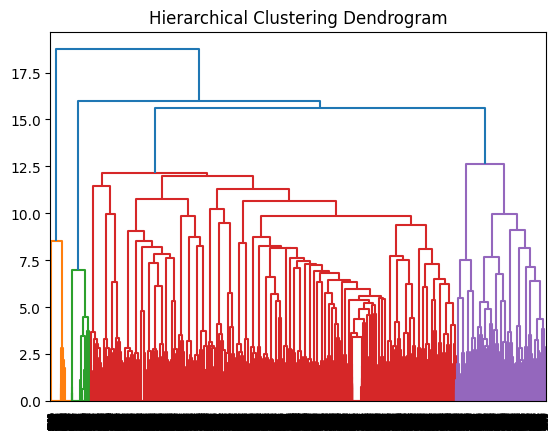

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Hierarchical Clustering with Word2Vec features:


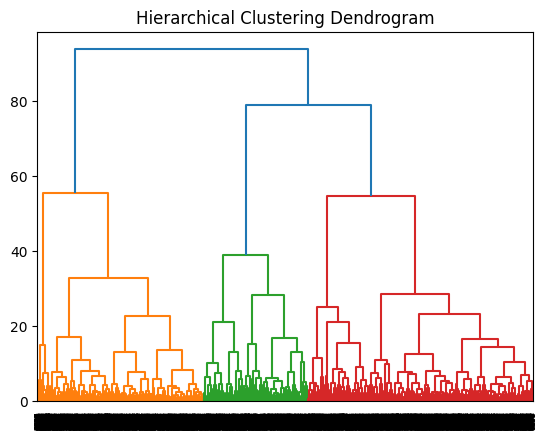

   id                                              tweet label  \
0   1  The CDC currently reports 99031 deaths. In gen...  real   
1   2  States reported 1121 deaths a small rise from ...  real   
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake   
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real   
4   5  Populous states can generate large case counts...  real   

                                          clean_text  cluster_kmeans_tfidf  \
0  cdc currently reports 99031 deaths . general d...                     0   
1  states reported 1121 deaths small rise last tu...                     1   
2  politically correct woman ( almost ) uses pand...                     4   
3  # indiafightscorona : 1524 # covid testing lab...                     0   
4  populous states generate large case counts loo...                     1   

   cluster_dbscan_tfidf  cluster_kmeans_w2v  cluster_dbscan_w2v  
0                    -1                   4                   0  
1 

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

# Ensure nltk resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load the data
url = 'https://raw.githubusercontent.com/narendranathreddy333/DATA/main/Constraint_Train.csv'
data = pd.read_csv(url)

# Preprocessing function to clean text
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [w for w in tokens if not w in stop_words]
    return " ".join(filtered_tokens)

data['clean_text'] = data['tweet'].apply(preprocess)

# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = vectorizer.fit_transform(data['clean_text']).toarray()

# Word2Vec model
tokenized_text = data['clean_text'].apply(lambda x: x.split())  # Tokenizing the text
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)

def vectorize(text, model):
    words = [word for word in text if word in model.wv.index_to_key]
    if words:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(100)

X_w2v = np.array([vectorize(text, w2v_model) for text in tokenized_text])

# Clustering Algorithms
def apply_clustering(X, method='kmeans', n_clusters=5):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        model = DBSCAN(eps=0.5, min_samples=5)
    elif method == 'hierarchical':
        model = linkage(X, method='ward')
        dendrogram(model)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.show()
        return None

    model.fit(X)
    return model.labels_

# Apply clustering methods to TF-IDF features
labels_kmeans_tfidf = apply_clustering(X_tfidf, 'kmeans')
labels_dbscan_tfidf = apply_clustering(X_tfidf, 'dbscan')
print("Hierarchical Clustering with TF-IDF features:")
apply_clustering(X_tfidf, 'hierarchical')

# Apply clustering methods to Word2Vec features
labels_kmeans_w2v = apply_clustering(X_w2v, 'kmeans')
labels_dbscan_w2v = apply_clustering(X_w2v, 'dbscan')
print("Hierarchical Clustering with Word2Vec features:")
apply_clustering(X_w2v, 'hierarchical')

# Add clustering labels to DataFrame for analysis
data['cluster_kmeans_tfidf'] = labels_kmeans_tfidf
data['cluster_dbscan_tfidf'] = labels_dbscan_tfidf
data['cluster_kmeans_w2v'] = labels_kmeans_w2v
data['cluster_dbscan_w2v'] = labels_dbscan_w2v

# Optional: display some results
print(data.head())

In [ ]:
#This code is designed to implement the BERT method, but it is experiencing long execution times,
#so I have separated this method for individual execution.




import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Load the data
url = 'https://raw.githubusercontent.com/narendranathreddy333/DATA/main/Constraint_Train.csv'
data = pd.read_csv(url)

# Function to preprocess and obtain BERT embeddings
def get_bert_embeddings(texts, batch_size=10):
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        embeddings.append(output.last_hidden_state[:, 0, :].cpu().numpy())

    return np.vstack(embeddings)

# Preprocess texts and obtain BERT embeddings
data['bert_embeddings'] = get_bert_embeddings(data['tweet'].tolist())

# Convert list of embeddings into an array
X_bert = np.array(list(data['bert_embeddings']))

# Clustering functions as defined previously
def apply_clustering(X, method='kmeans', n_clusters=5):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == 'dbscan':
        model = DBSCAN(eps=0.5, min_samples=5)
    elif method == 'hierarchical':
        model = linkage(X, method='ward')
        dendrogram(model)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.show()
        return None

    model.fit(X)
    return model.labels_

# Apply clustering to BERT features
print("KMeans Clustering with BERT features:")
labels_kmeans_bert = apply_clustering(X_bert, 'kmeans')
print("DBSCAN Clustering with BERT features:")
labels_dbscan_bert = apply_clustering(X_bert, 'dbscan')
print("Hierarchical Clustering with BERT features:")
apply_clustering(X_bert, 'hierarchical')

# Add BERT clustering labels to DataFrame for analysis
data['cluster_kmeans_bert'] = labels_kmeans_bert
data['cluster_dbscan_bert'] = labels_dbscan_bert

# display some results
print(data.head())


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.
 In the sample data, K-means has assigned tweets to distinct groups based on TF-IDF features, showcasing its efficiency with predefined cluster numbers. DBSCAN has marked some tweets as outliers, highlighting its ability to handle noise and identify dense clusters, which is beneficial for distinguishing unusual data patterns. Word2Vec influences clustering by capturing semantic similarities, possibly leading to nuanced groupings. Although not shown, Hierarchical clustering would illustrate relationships between clusters, and BERT (Assuming) enhance these methods by providing richer, context-aware embeddings for more coherent clustering.
.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
The exercise was a bit challenging for me, particularly when working with BERT,
as it was time-consuming and led to crashes at the end of the code execution.
To improve future experiences, I might consider using lighter model variants like DistilBERT,
processing data in smaller batches, or utilizing more robust computational resources to handle
the intensive processing demands more effectively and avoid similar issues.


'''